In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix
import seaborn as sns  



from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading

import statistics as stat

# Hello:)

plt.rcParams['figure.figsize'] = (8, 8)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Custom Dataset

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
from PIL import Image, ImageOps 
from torchvision import transforms
import csv


class Number16(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        with open(csv_file, "r") as file:
          classes = set()
          csv_reader = csv.reader(file)

          for i, row in enumerate(csv_reader):
            if i != 0:
              column = row[1]
              classes.add(column)


        self.classes = classes


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])

        for i in img_path:
          if i == " ":
            img_path = img_path.replace(' ', '')

        image = Image.open(img_path)
        image = ImageOps.exif_transpose(image)
        image = image.convert('L')

        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label


excel = 'DATASET/Excel.csv'
imgs = 'DATASET/img'




dataset = Number16(
    csv_file = excel,
    root_dir = imgs,
    transform = transforms.Compose([
        transforms.Resize((128, 128)),    # Resize to 128x128
        transforms.ToTensor()             # Convert the image to a tensor
    ])
)



train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset,
                                          batch_size=256,
                                          shuffle=True),

    'test'  : torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=True)
}





print("Number of images in dataset: ",len(dataset))

print("this dataset contains",len(dataset.classes) ,"clases: ", dataset.classes)

print("Number of images in training dataset: ",len(train_dataset))

print("Number of images in testing dataset: ",len(test_dataset))

Number of images in dataset:  3840
this dataset contains 16 clases:  {'4', '7', '3', '15', '6', '13', '11', '10', '2', '0', '14', '8', '1', '9', '5', '12'}
Number of images in training dataset:  3072
Number of images in testing dataset:  768


In [ ]:
dataset.annotations

In [ ]:
# Particular image plotting

index = 3838
image, label = dataset[index]

if not isinstance(image, np.ndarray):
    image = np.array(image)
    image = np.squeeze(image)

# Plot the image
plt.imshow(image, cmap='gray')  # Adjust the colormap if necessary
plt.title(f'{label} index: {index}' )
plt.show()

In [ ]:
# Random multiple images plotting
import random
figure = plt.figure(figsize=(10, 8))
cols, rows = 6, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{label}, inx:({sample_idx})')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# AI 

In [3]:
#                   PRINCIPLE
# 1. too many neurons results into overfitting, low generalization because the AI is trained aggresively on the training dataset



#                   USEFULL PROGRAMMING
# 1. nn.Linear(layer1, layer2) is a fully connected 2 layers



import torch.nn as nn

class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential( nn.Conv2d(                   # 128*128
        in_channels=1,
        out_channels=16,
        kernel_size=(3,3)                     # 126*126
        ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2
                    )  )                  # 63*63


    self.conv2 = nn.Sequential ( nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=(3,3)                # 61*61
        ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2
                    )  )                      # 30*30
    

    self.conv3 = nn.Sequential(nn.Conv2d(     
      in_channels=32,
      out_channels=64,
      kernel_size=(3,3)                          # 28*28      
      ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2                 
                    )   )                        # 14*14*64
    



    self.fc1 = nn.Sequential(
        nn.Linear(14*14*64, 512),
        nn.ReLU()
        )
    
    self.dropout = nn.Dropout(0.5)

    self.out = nn.Sequential(
        nn.Linear(512, 16),
        nn.Softmax(dim=1)
        )
    


    



  def forward(self, data):
    data = self.conv1(data)
    data = self.conv2(data)
    data = self.conv3(data)


    data = data.view(data.size(0), -1)
    data = self.fc1(data)
    data = self.dropout(data)
    data = self.out(data)
    return data



# 350 -> 512 neurons
# 32 -> 64 feature maps entering neuron layers


In [4]:
### TESTING FUNCTION


from torch.autograd import Variable
import time


def batch_test(cnn, loaders, device, epoch=None, writer=None, data_collect=False): 

    cnn.eval()

    # Train the model
    total_step = len(loaders['test'])
    losses = []
    accuracies = []
    
    # for confusion matrix
    b_y_list = []
    predictions_list = []

    # for false predictitons
    wrong_predictions = []
    


    with torch.no_grad():
        for i, (images, labels) in enumerate(loaders['test']):         

            b_x = images.to(device=device)        #data
            b_y = labels.to(device=device)    #target/label

            output = cnn.forward(b_x)

            loss = loss_func(output, b_y)
         

            #  Calculate 'running' training accuracy
            _, predictions = output.max(1)
            num_correct = (predictions == b_y).sum()
            running_train_acc = float(num_correct) / float(b_x.shape[0])
            accuracies.append(running_train_acc)
            losses.append(loss.item())
            
            if data_collect:
                b_y_list.extend(b_y.cpu().numpy())
                predictions_list.extend(predictions.cpu().numpy())

                for i in range(len(predictions)):

                    if predictions[i] != b_y[i]:
                        wrong_predictions.append([int(predictions[i].cpu()), b_x[i].cpu().numpy()])


    accuracy = stat.mean(accuracies)
    loss = stat.mean(losses)

    if data_collect:
        conf_matrix = ConfusionMatrixDisplay.from_predictions(b_y_list, predictions_list, cmap="Blues")

    else:
        # logging data
        writer.add_scalar('Loss/test', loss, epoch)
        writer.add_scalar('Accuracy/test', accuracy, epoch)
        conf_matrix = None
        wrong_predictions = None

    
    return accuracy, conf_matrix, wrong_predictions




In [5]:
### TRAINING FUNCTION


from torch.autograd import Variable
import time



def train(num_epochs, cnn, loaders, layout, filename):  

    cnn.train()

    writer = SummaryWriter()
    # writer.add_custom_scalars(layout)


    total_step = len(loaders['train'])

    losses = []
    accuracies = []
    accuracie_best = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):         

            b_x = images.to(device=device)        #data
            b_y = labels.to(device=device)    #target/label

            output = cnn.forward(b_x)


            # backpropagation

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
         

            #  Calculate 'running' training accuracy
            features = b_x.reshape(b_x.shape[0], -1)
            img_grid = torchvision.utils.make_grid(b_x)
            _, predictions = output.max(1)
            num_correct = (predictions == b_y).sum()
            running_train_acc = float(num_correct) / float(b_x.shape[0])
            accuracies.append(running_train_acc)
            losses.append(loss.item())
            
        

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))



        # validation on data yet unseen
        test_accuracy, _, _ = batch_test(cnn, loaders, device, epoch, writer, False)

        if test_accuracy > accuracie_best:
            accuracie_best = test_accuracy
            best_model = cnn

        accuracy = stat.mean(accuracies)
        loss = stat.mean(losses)


        # logging data
        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('Accuracy/train', accuracy, epoch)
        
    best_model.to(device)
    torch.save(best_model.state_dict(), f"best/best{accuracie_best}")

In [ ]:
from torch import optim


# layout = {
#     "Epoch Progress": {
#         "losses": ["Multiline", ["Loss/train", "Loss/test"]],
#         "accuracies": ["Multiline", ["Accuracy/train", "Accuracy/test"]],
#     },
# }
layout = False    # just uncomment the layout above and one line of code in train function


iterate = 3
num_epochs = 1000
filename = 0


for i in range(iterate):
    cnn = CNN()
    cnn.to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.001, weight_decay =  0.001)

    train(num_epochs, cnn, loaders, layout, filename) 

    filename += 1
 

75 images mistakenaly classified
This is the actual accuracy: 0.90234375


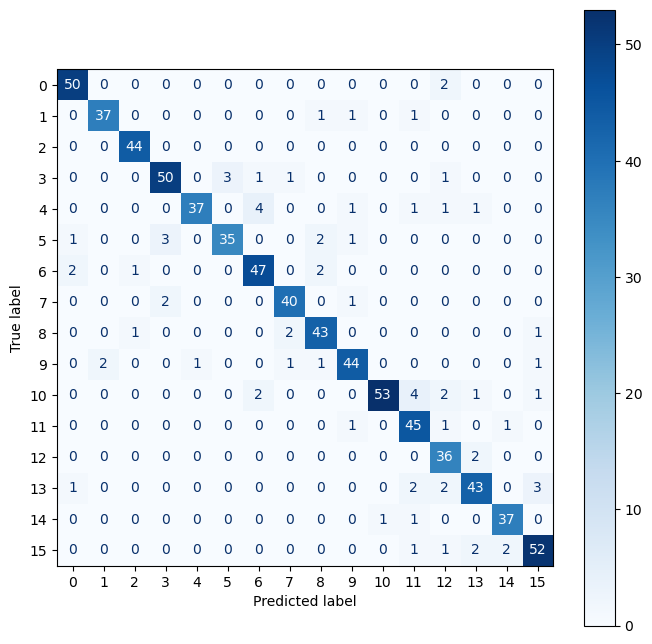

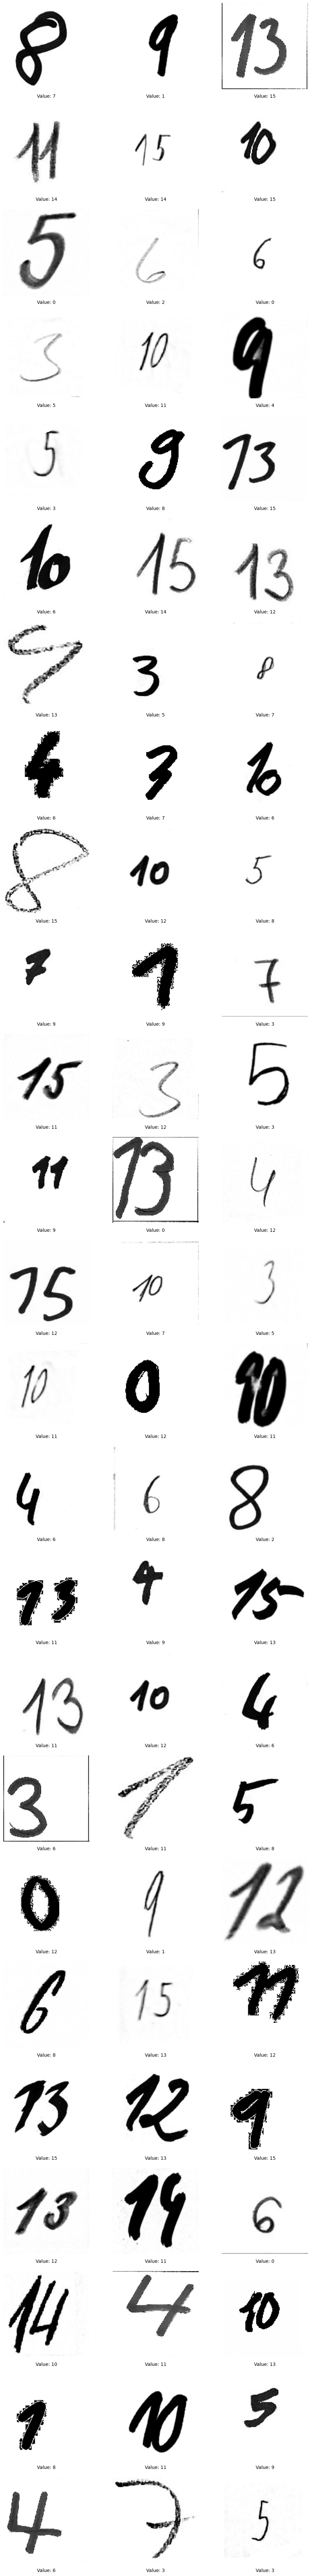

In [28]:
## VISUALIZE conf_matrix, images, predictions

from torch import optim


cnn = CNN()
cnn.load_state_dict(torch.load("best/best0.9127604166666666"))      # loading model
cnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001, weight_decay =  0.001)

# collecting data to optimize
accuracy, conf_matrix, wrong_predictions = batch_test(cnn, loaders, device, False, False, True)




images = []
values = []

for i in wrong_predictions:
    values.append(i[0])

    image = np.reshape(i[1], (128, 128))
    images.append(image)

print(f'{len(values)} images mistakenaly classified')
print(f'This is the actual accuracy: {accuracy}')

# Calculate the number of rows needed
num_rows = (len(images) + 2) // 3  # Adding 2 and using integer division to ensure rounding up

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i, (image, value) in enumerate(zip(images, values)):
    row_index = i // 3
    col_index = i % 3
    ax = axes[row_index, col_index]
    ax.imshow(image, cmap='gray')  # Display image
    ax.axis('off')  # Turn off axis
    ax.annotate(f'Value: {value}', (0.5, -0.1), xycoords='axes fraction', ha='center')  # Annotate value beneath the image

# Hide empty subplots, if any
for ax_row in axes[num_rows:]:
    for ax in ax_row:
        ax.axis('off')

plt.show()

7
[9, 2, 7, 0, 12, 4, 15]


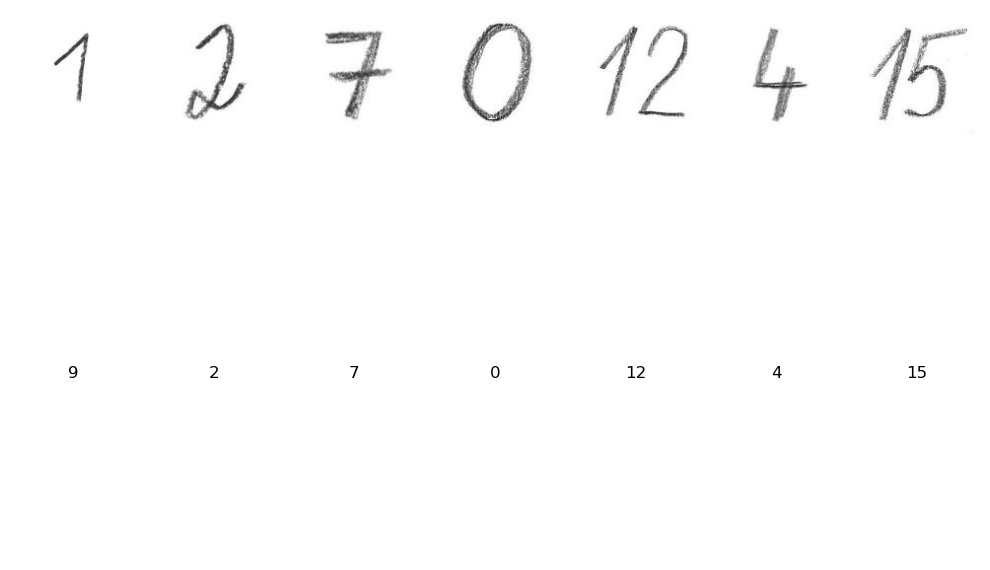

In [42]:
############ TRYING OUT THE MODEL ON REAL LIFE EXAMPLES ##############



####### LOADING DATA ########

import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_folder = "mama-cisla"

# List to store image file paths
image_files = []

# Iterate over files in the image folder
for filename in os.listdir(image_folder):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        # Construct the full file path
        filepath = os.path.join(image_folder, filename)
        # Append the file path to the list
        image_files.append(filepath)

images = image_files


from PIL import Image
import torch
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Grayscale(),         # Convert images to grayscale
    transforms.Resize((128, 128)),  # Resize the images to a fixed size (e.g., 128x128)
    transforms.ToTensor(),          # Convert images to tensors
])

images = torch.stack([transform(Image.open(img_path)) for img_path in images])
images = images.to(device)








####### EVALUATION ########

cnn.eval()
all_predictions = []

with torch.no_grad():

    for i in range(len(images)):
        images[i] = images[i].to(device)


    test_output = cnn(images)        # 7 x 16


    for i in range(7):
        pred_y = torch.max(test_output[i], 0)[1].data 
        pred_y = pred_y.data
        all_predictions.append(pred_y)

all_predictions = [t.item() for t in all_predictions]







####### VISUALIZATION ########

integers = all_predictions
num_images = len(image_files)
rows = 2  
cols = num_images

fig = plt.figure(figsize=(10, 7))

for i, (image_path, integer) in enumerate(zip(image_files, integers)):

    ax = fig.add_subplot(rows, cols, i + 1)
    image = Image.open(image_path)
    

    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    ax.imshow(image)
    ax.axis('off')
    

    ax = fig.add_subplot(rows, cols, num_images + i + 1)
    ax.text(0.5, 0.5, str(integer), fontsize=12, ha='center')
    ax.axis('off')

plt.tight_layout()
plt.show()

